In [3]:
import warnings

warnings.filterwarnings(action='ignore')

from os.path import join
import pandas as pd
import numpy  as np
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sample_data = pd.read_csv(join('data', join('kaggle', 'train.csv')))

#전처리(변수 간 세부 수치는 SQL 통해 확인하였음)

In [4]:
sample_data

id  age         workclass  fnlwgt     education  education_num  \
0          0   40           Private  168538       HS-grad              9   
1          1   17           Private  101626           9th              5   
2          2   18           Private  353358  Some-college             10   
3          3   21           Private  151158  Some-college             10   
4          4   24           Private  122234  Some-college             10   
...      ...  ...               ...     ...           ...            ...   
26044  26044   57           Private  250201          11th              7   
26045  26045   23           Private  238092     Bachelors             13   
26046  26046   78                 ?  165694       Masters             14   
26047  26047   26  Self-emp-not-inc  151626       HS-grad              9   
26048  26048   20                 ?   99891  Some-college             10   

           marital_status         occupation   relationship   race     sex  \
0      Married-civ-spouse              Sales        Husband  White    Male   
1           Never-married  Machine-op-inspct      Own-child  White    Male   
2           Never-married      Other-service      Own-child  White    Male   
3           Never-married     Prof-specialty      Own-child  White  Female   
4           Never-married       Adm-clerical  Not-in-family  Black  Female   
...                   ...                ...            ...    ...     ...   
26044  Married-civ-spouse      Other-service        Husband  White    Male   
26045       Never-married     Prof-specialty      Own-child  White    Male   
26046             Widowed                  ?  Not-in-family  White  Female   
26047       Never-married     Prof-specialty      Own-child  Black  Female   
26048       Never-married                  ?      Own-child  White  Female   

       capital_gain  capital_loss  hours_per_week native_country income  
0                 0             0              60  United-States   >50K  
1                 0             0              20  United-States  <=50K  
2                 0             0              16  United-States  <=50K  
3                 0             0              25  United-States  <=50K  
4                 0             0              20              ?  <=50K  
...             ...           ...             ...            ...    ...  
26044             0             0              52  United-States  <=50K  
26045             0             0              40  United-States  <=50K  
26046             0             0              15  United-States  <=50K  
26047             0             0              40  United-States  <=50K  
26048             0             0              30  United-States  <=50K  

[26049 rows x 16 columns]

income 변수 전처리(Binary)

In [5]:
sample_data['income'] = sample_data['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [6]:
sample_data.drop(columns=['id'],inplace=True)

In [7]:
sample_data

age         workclass  fnlwgt     education  education_num  \
0       40           Private  168538       HS-grad              9   
1       17           Private  101626           9th              5   
2       18           Private  353358  Some-college             10   
3       21           Private  151158  Some-college             10   
4       24           Private  122234  Some-college             10   
...    ...               ...     ...           ...            ...   
26044   57           Private  250201          11th              7   
26045   23           Private  238092     Bachelors             13   
26046   78                 ?  165694       Masters             14   
26047   26  Self-emp-not-inc  151626       HS-grad              9   
26048   20                 ?   99891  Some-college             10   

           marital_status         occupation   relationship   race     sex  \
0      Married-civ-spouse              Sales        Husband  White    Male   
1           Never-married  Machine-op-inspct      Own-child  White    Male   
2           Never-married      Other-service      Own-child  White    Male   
3           Never-married     Prof-specialty      Own-child  White  Female   
4           Never-married       Adm-clerical  Not-in-family  Black  Female   
...                   ...                ...            ...    ...     ...   
26044  Married-civ-spouse      Other-service        Husband  White    Male   
26045       Never-married     Prof-specialty      Own-child  White    Male   
26046             Widowed                  ?  Not-in-family  White  Female   
26047       Never-married     Prof-specialty      Own-child  Black  Female   
26048       Never-married                  ?      Own-child  White  Female   

       capital_gain  capital_loss  hours_per_week native_country  income  
0                 0             0              60  United-States       1  
1                 0             0              20  United-States       0  
2                 0             0              16  United-States       0  
3                 0             0              25  United-States       0  
4                 0             0              20              ?       0  
...             ...           ...             ...            ...     ...  
26044             0             0              52  United-States       0  
26045             0             0              40  United-States       0  
26046             0             0              15  United-States       0  
26047             0             0              40  United-States       0  
26048             0             0              30  United-States       0  

[26049 rows x 15 columns]

특이값 확인 과정

In [8]:
#csv 파일에서 각 컬럼 별 unique값 확인
columns = sample_data.columns.tolist()

for i in columns:
    print(i)
    print(sample_data[i].unique())

age
[40 17 18 21 24 43 37 47 41 34 44 50 39 32 54 26 29 53 31 46 23 20 22 27
 51 57 25 76 38 66 64 58 45 52 67 65 35 19 68 28 33 36 63 62 42 59 49 30
 56 48 61 60 55 72 69 74 81 71 84 70 80 78 90 79 75 73 83 82 85 77 87 88
 86]
workclass
['Private' 'State-gov' '?' 'Self-emp-not-inc' 'Local-gov' 'Federal-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
fnlwgt
[168538 101626 353358 ... 238092 165694  99891]
education
['HS-grad' '9th' 'Some-college' 'Bachelors' '11th' '1st-4th' '5th-6th'
 'Assoc-acdm' '10th' 'Prof-school' '7th-8th' 'Masters' 'Assoc-voc'
 'Doctorate' '12th' 'Preschool']
education_num
[ 9  5 10 13  7  2  3 12  6 15  4 14 11 16  8  1]
marital_status
['Married-civ-spouse' 'Never-married' 'Separated' 'Married-spouse-absent'
 'Divorced' 'Widowed' 'Married-AF-spouse']
occupation
['Sales' 'Machine-op-inspct' 'Other-service' 'Prof-specialty'
 'Adm-clerical' 'Craft-repair' '?' 'Handlers-cleaners' 'Farming-fishing'
 'Exec-managerial' 'Transport-moving' 'Protective-serv' 'Tech-supp

특이값(?) 결측치 처리

In [9]:
#값들 중 ? 있는 부분 확인. nan 값으로 변경
sample_data = sample_data.replace('?',np.nan)

각 변수 별 개수 확인

In [10]:
for c in columns:
    print('columns:',c)
    print(sample_data[c].value_counts())

columns: age
31    712
35    710
23    706
36    700
34    697
     ... 
83      5
88      3
85      2
87      1
86      1
Name: age, Length: 73, dtype: int64
columns: workclass
Private             18123
Self-emp-not-inc     2030
Local-gov            1692
State-gov            1043
Self-emp-inc          877
Federal-gov           765
Without-pay            11
Never-worked            6
Name: workclass, dtype: int64
columns: fnlwgt
203488    11
123011    10
121124    10
126675    10
117963    10
          ..
177839     1
519627     1
157599     1
200360     1
125489     1
Name: fnlwgt, Length: 18422, dtype: int64
columns: education
HS-grad         8433
Some-college    5800
Bachelors       4344
Masters         1378
Assoc-voc       1096
11th             922
Assoc-acdm       842
10th             731
7th-8th          505
Prof-school      466
9th              418
12th             359
Doctorate        316
5th-6th          265
1st-4th          134
Preschool         40
Name: education, dtype: int6

결측치 확인

In [11]:
pd.isna(sample_data).sum()

age                  0
workclass         1502
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1508
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     456
income               0
dtype: int64

연속형, 범주형 변수 구분

In [12]:
#연속형, 범주형 구분
cat_columns = [c for (c, t) in zip(sample_data.dtypes.index, sample_data.dtypes) if t == 'O'] 
num_columns = [c for c in sample_data.columns if c not in cat_columns]

In [13]:
#연속형의 경우 분포 확인
cat_columns

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

범주형#1)worckclass 분포

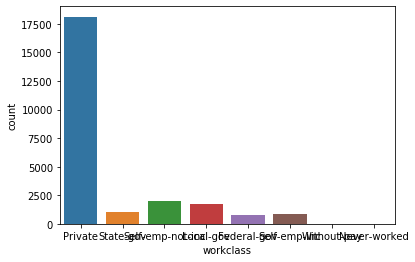

In [14]:
#범주형의 경우 막대 그래프
sns.countplot('workclass',data=sample_data)


In [ ]:
#각 인종 별 workclass 수 확인(by SQL)

범주형#2)education 분포

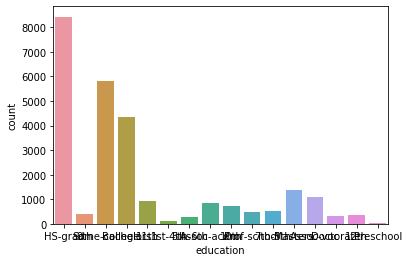

In [15]:
sns.countplot('education',data=sample_data)

범주형#3)occupation 분포(?-> 예측하는 간단한 모델 작성 필요하다고 판단)

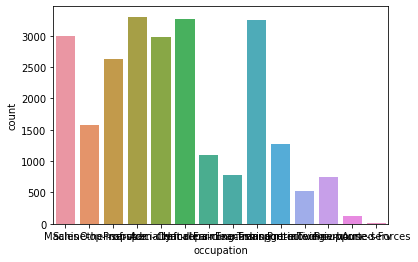

In [16]:
sns.countplot('occupation',data=sample_data)
#다양한 분포. 

범주형#4)소득과 성별에 따른 나이 분포 확인

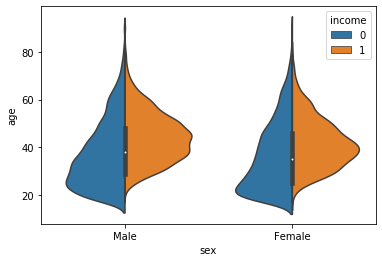

In [17]:
#소득에 따른 성별과 나이 분포 확인
sns.violinplot('sex','age',hue='income',data=sample_data,split=True)

범주형#5)인종 간 소득 분포

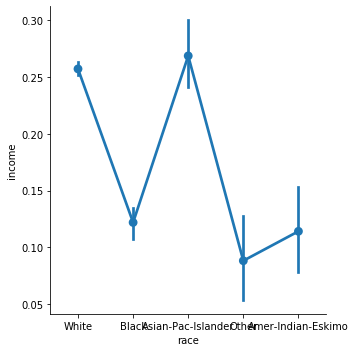

In [18]:
#인종 간 소득 분포
sns.factorplot('race','income',data=sample_data)

heatmap 확인

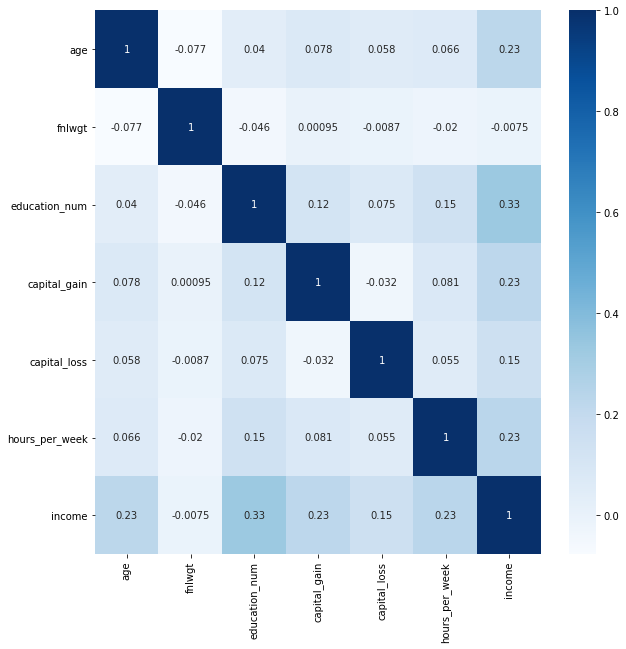

In [19]:
#연속형 분포 확인
plt.figure(figsize=(10,10))
sns.heatmap(data = sample_data.corr(), annot=True, cmap='Blues')

hours_per_week 분포(정규화 필요)

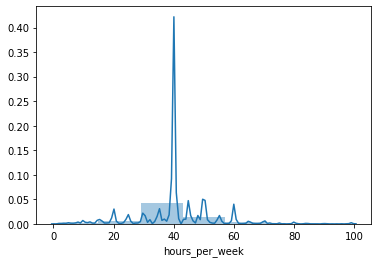

In [24]:
sns.distplot(sample_data['hours_per_week'],bins=7)

education과 education_num 어떤 차이 있는지 확인(차이 없음을 확인)

In [32]:
#eudcation 변수 와 education_num 차이가 무엇인지. - 같은 것을 확인할 수 있었음.
sample_data['education'].value_counts()

HS-grad         8433
Some-college    5800
Bachelors       4344
Masters         1378
Assoc-voc       1096
11th             922
Assoc-acdm       842
10th             731
7th-8th          505
Prof-school      466
9th              418
12th             359
Doctorate        316
5th-6th          265
1st-4th          134
Preschool         40
Name: education, dtype: int64

In [33]:
sample_data['education_num'].value_counts()

9     8433
10    5800
13    4344
14    1378
11    1096
7      922
12     842
6      731
4      505
15     466
5      418
8      359
16     316
3      265
2      134
1       40
Name: education_num, dtype: int64

결론
capital의 경우 capital_gain - capital_loss (새로운 변수 생성)
연속형 변수의 경우 정규화 작업 실시
education = education_num  (연습을 위해 education 사용. 그룹화 예정)
native_country -> 지역 별 그룹화 예정
workclass, occupation 의 경우 ? 값 존재. 이에 대한 간단한 예측 모델 생성 후 전체적인 모델 생성 예정(native_country의 결측치 경우, 미국으로 대체(최빈값))

지금으로서는 race가 binary classification에 있어 영향이 큰 변수임을 유추해볼 수 있음.